In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 6s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


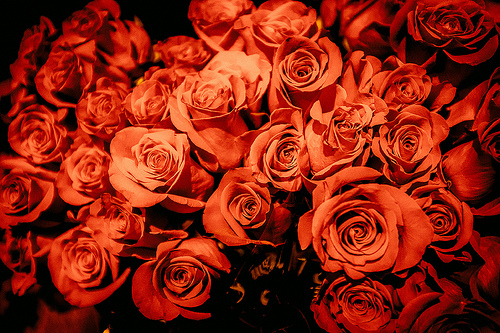

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[2]))

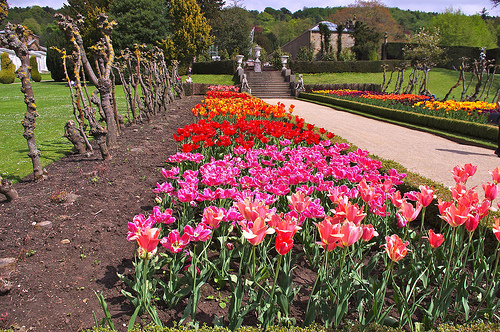

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[9]))

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


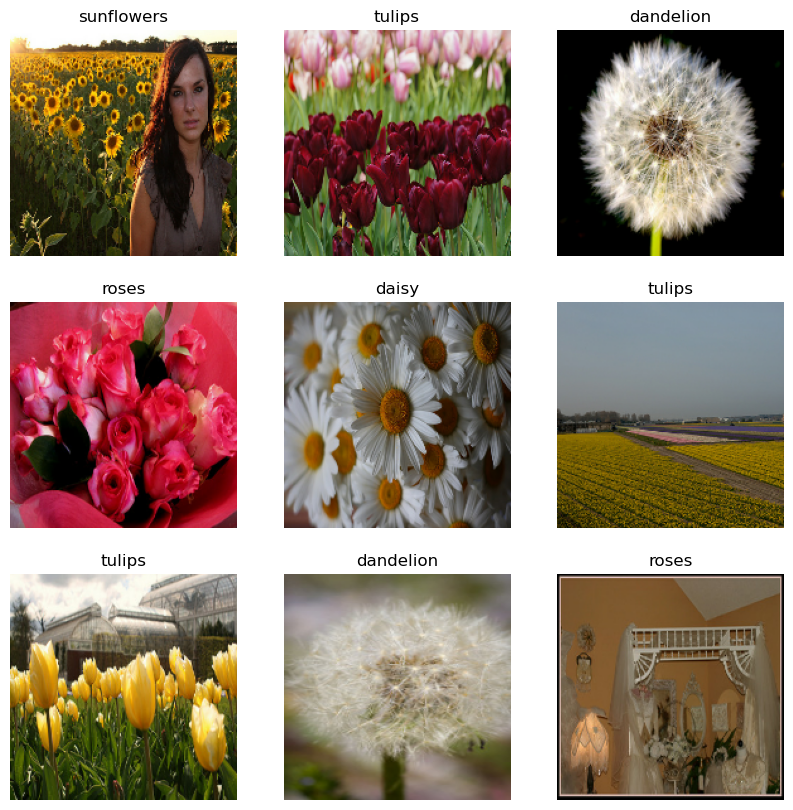

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax =  plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
normalization_layer = layers.Rescaling(1./255)

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [21]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [24]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 35s 369ms/step - loss: 1.3679 - accuracy: 0.4322 - val_loss: 1.1271 - val_accuracy: 0.5613
Epoch 2/10
92/92 [==============================] - 34s 374ms/step - loss: 1.0113 - accuracy: 0.5920 - val_loss: 0.9761 - val_accuracy: 0.6240
Epoch 3/10
92/92 [==============================] - 35s 380ms/step - loss: 0.8291 - accuracy: 0.6829 - val_loss: 0.8710 - val_accuracy: 0.6703
Epoch 4/10
92/92 [==============================] - 34s 367ms/step - loss: 0.6623 - accuracy: 0.7480 - val_loss: 0.8446 - val_accuracy: 0.6730
Epoch 5/10
92/92 [==============================] - 33s 364ms/step - loss: 0.4732 - accuracy: 0.8341 - val_loss: 0.9655 - val_accuracy: 0.6431
Epoch 6/10
92/92 [==============================] - 33s 363ms/step - loss: 0.2969 - accuracy: 0.9005 - val_loss: 1.1843 - val_accuracy: 0.6267
Epoch 7/10
92/92 [==============================] - 35s 378ms/step - loss: 0.1753 - accuracy: 0.9479 - val_loss: 1.3090 - val_accuracy: 0.6267

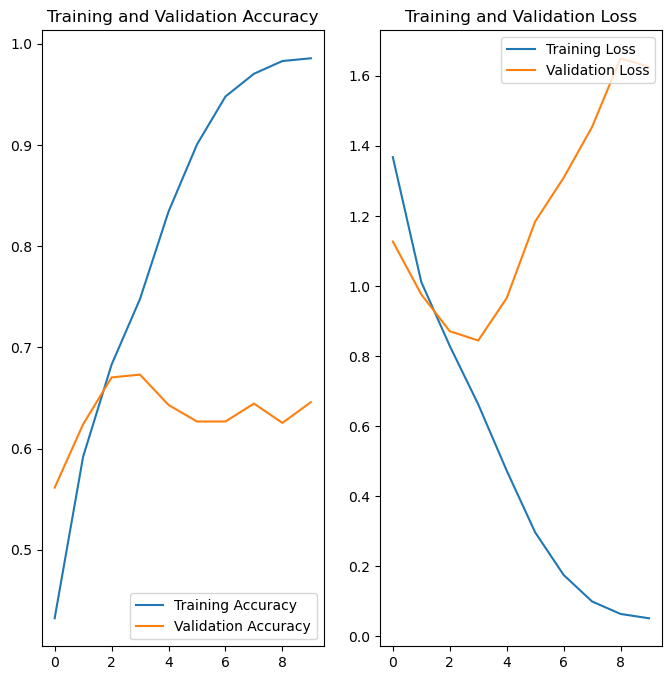

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")
plt.show()


In [26]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal",
     input_shape=(img_height, img_width, 3)),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.1),])

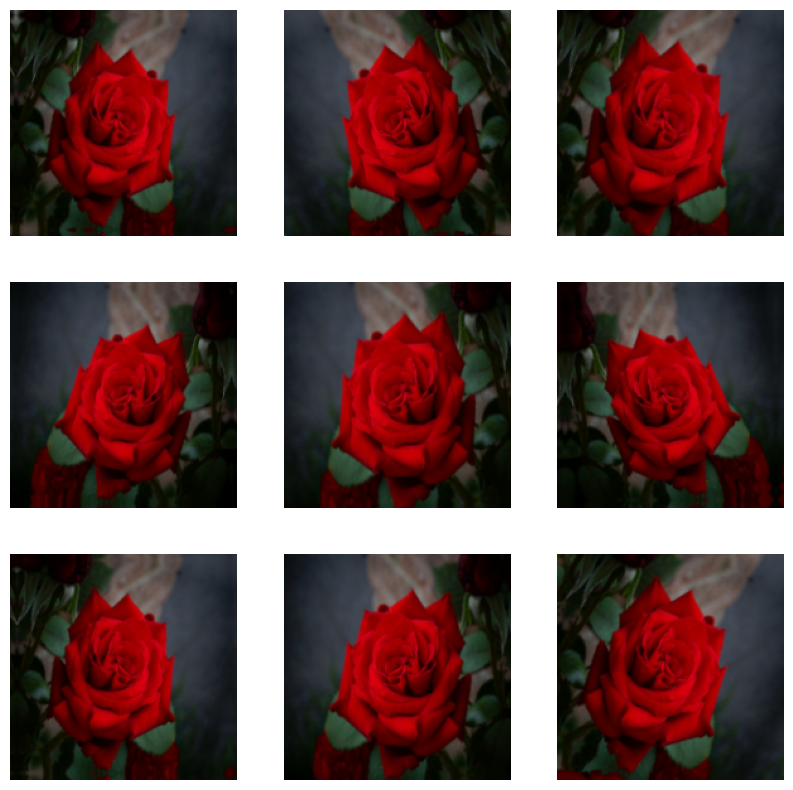

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [28]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),\
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,name="outputs")

])

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [32]:
epochs = 15
model.fit(
    train_ds,
    validation_data =val_ds,
    epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 39s 417ms/step - loss: 1.3647 - accuracy: 0.4155 - val_loss: 1.1473 - val_accuracy: 0.5436
Epoch 2/15
92/92 [==============================] - 35s 383ms/step - loss: 1.0384 - accuracy: 0.5800 - val_loss: 0.9602 - val_accuracy: 0.6294
Epoch 3/15
92/92 [==============================] - 35s 385ms/step - loss: 0.9141 - accuracy: 0.6332 - val_loss: 0.8497 - val_accuracy: 0.6757
Epoch 4/15
92/92 [==============================] - 36s 390ms/step - loss: 0.8384 - accuracy: 0.6781 - val_loss: 0.8062 - val_accuracy: 0.6826
Epoch 5/15
92/92 [==============================] - 36s 393ms/step - loss: 0.7815 - accuracy: 0.7006 - val_loss: 0.8432 - val_accuracy: 0.6826
Epoch 6/15
92/92 [==============================] - 35s 382ms/step - loss: 0.7430 - accuracy: 0.7101 - val_loss: 0.8144 - val_accuracy: 0.6826
Epoch 7/15
92/92 [==============================] - 36s 387ms/step - loss: 0.7001 - accuracy: 0.7313 - val_loss: 0.7867 - val_accuracy: 0.6989

ValueError: x and y must have same first dimension, but have shapes (15,) and (10,)

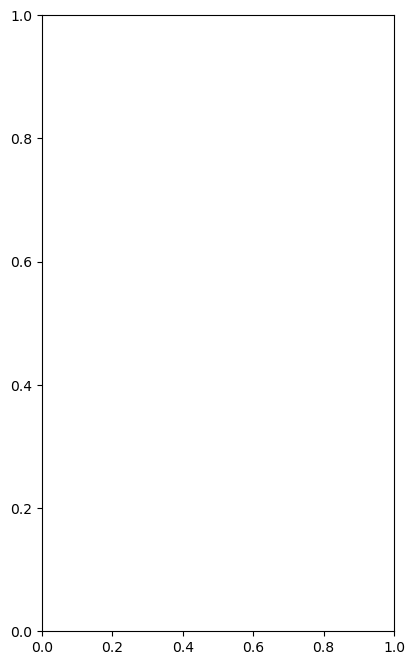

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 84ms/step
This image most likely belongs to sunflowers with a 99.52 percent confidence.
